In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Non-parametric Bayesian Network"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "anna.buch@uni-heidelberg.de"

##  Non-parametric Bayesian Network

Non-parametric Bayesian Network applied on preselected feautre space from HCMC reutnred from feature selection, target variabels to predict are the relative commercial content losses [fraction of content loss to total content value ] of shophouses and the relative losses due to business interurption [% reduction during the flood, relative to monthly sales]

BN package: https://github.com/mike-mendoza/py_banshee

In [2]:
import sys, os
from pathlib import Path
import numpy as np
import pandas as pd

from pylab import *
import matplotlib.pyplot as plt
import seaborn as sns

from py_banshee.rankcorr import bn_rankcorr
from py_banshee.bn_plot import bn_visualize
from py_banshee.copula_test import cvm_statistic
from py_banshee.d_cal import gaussian_distance
from py_banshee.prediction import inference

import src.settings as s
import src.figures as f
import src.evaluation_utils as eu
import src.preprocessing as pp

seed = s.seed
pd.set_option("display.max_columns", None)
#plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings("ignore")

targets = [("degree of rcloss", "degree of rcloss"), ("rbred","rbred")]
target, target_plot = targets[1]
pred_target = f"pred_{target}"

## Define name of output figure with BN; used by bn_visualize
fig_name = f"bn_{target}"

## save models and their evaluation in following folders:
INPATH_DATA = Path(s.INPATH_DATA)
## create output paths
OUTPATH_FEATURES, OUTPATH_BN = [
    pp.create_output_dir( "." / Path(d) / "rbred") for d in  
    [ 
        s.OUTPATH_FEATURES, s.OUTPATH_BN
    ]
]


c:\Users\Anna\miniforge-pypy3\envs\py396_c3\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Create  ..\..\model_results\selected_features\rbred
Create  ..\..\model_results\bayesian_network\rbred


In [ ]:
## load predictors set and addtional features from feature selection for BN (HCMC, rbred)
df_hcmc_org = pd.read_excel(f"{OUTPATH_FEATURES}/final_predictors_rbred.xlsx") #f"final_predictors_rbred_income_cv.xlsx")

##  use nice feature names
df_hcmc_org.rename(columns=s.feature_names_plot, inplace=True) 
try:    df_hcmc_org.rename({"water depth inside": "water depth"}, axis=1, inplace=True)
except:   pass

df_hcmc_org.reset_index(drop=True, inplace=True)  # better for merging different sources, when indexes are all the same

## remove geometry and other features which are just needed for analysis
df_hcmc = df_hcmc_org

print(df_hcmc.shape)
df_hcmc.tail(2)


(360, 15)


,rbred,Emergency measures,Building age,Water depth,No. employees,Flow velocity,Flood experience,Resilience,Inundation duration,Structural measures,Mthly. sales,Non-structural measures,Building area,Mthly. income,Contaminations
358,10,0.500000,25.0,70.0,1,0.1,151,1.0,5.0,0.0,276.2,0.75,80.0,110.5,1
359,0,0.333333,5.0,100.0,2,0.1,36,0.0,3.0,0.0,736.5,0.25,33.0,18.4,1


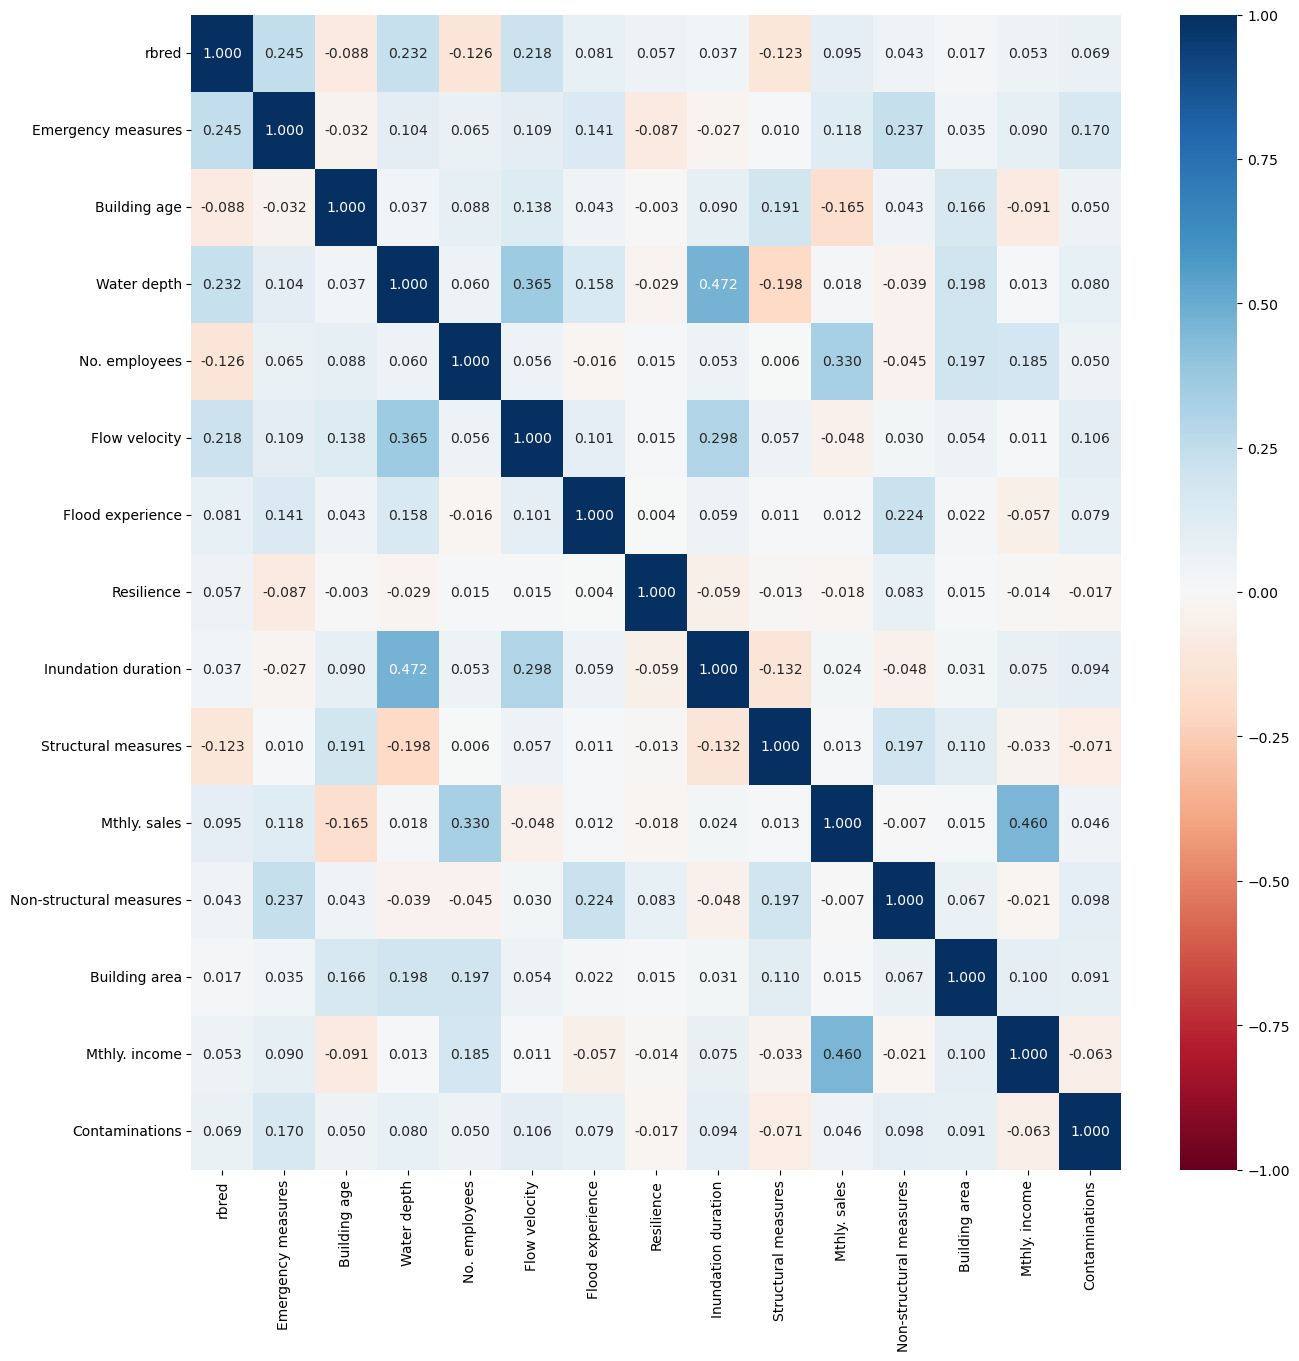

In [4]:
## find predictor with highest unconditional correlation to target
plt.figure(figsize=(15,15))
heatmap = sns.heatmap(df_hcmc.corr(method="spearman"), 
                      vmin=-1, vmax=1, 
                      annot=True, fmt=".3f", 
                      cmap="RdBu")


--> water depth  and emergency measures has strongest unconditonal correlation with rbred

## Construct BN

In [5]:
df_hcmc.columns = [x.lower() for x in df_hcmc.columns]
df_hcmc.columns

Index(['rbred', 'emergency measures', 'building age', 'water depth',
       'no. employees', 'flow velocity', 'flood experience', 'resilience',
       'inundation duration', 'structural measures', 'mthly. sales',
       'non-structural measures', 'building area', 'mthly. income',
       'contaminations'],
      dtype='object')

In [6]:

# Define the variable names
names_list = ["rbred",  'water depth', 'no. employees', "flow velocity",  
              "structural measures",
              ]
print(df_hcmc.columns)


# # Select the columns to use in the NPBN
df_hcmc_bn = df_hcmc[names_list]

names = {k: i for i, k in enumerate(names_list)}

print("Using following features:\n", names)

Index(['rbred', 'emergency measures', 'building age', 'water depth',
       'no. employees', 'flow velocity', 'flood experience', 'resilience',
       'inundation duration', 'structural measures', 'mthly. sales',
       'non-structural measures', 'building area', 'mthly. income',
       'contaminations'],
      dtype='object')
Using following features:
 {'rbred': 0, 'water depth': 1, 'no. employees': 2, 'flow velocity': 3, 'structural measures': 4}


In [7]:
# Extract number of nodes from df_hcmc
N = df_hcmc_bn.shape[1]  # number of nodes == number of features + target
print(N)

# Defining the structure of the BN
parent_cell = [None]*N
parent_cell[0] = [1, 2, 3, 4]                                               #   target (parents: all other features)
parent_cell[1] = [3, 4]                                                     # wd
parent_cell[2] = []                                                         # employee
parent_cell[3] = []                                                         # fv 
parent_cell[4] = []                                                         # struct. m 


parent_cell

5


[[1, 2, 3, 4], [3, 4], [], [], []]

<Figure size 500x500 with 0 Axes>

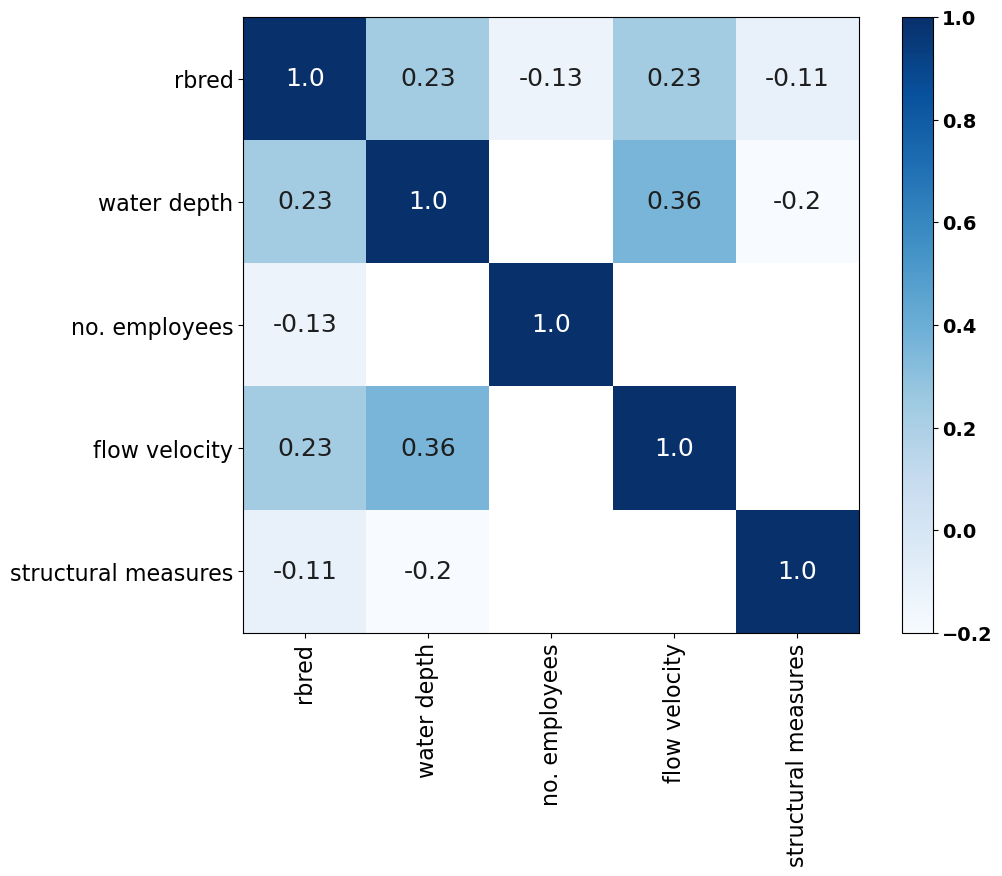

In [8]:
#-----------------------------------------------------------------------------
# Function 1 - bn_rankcorr - Conditional rank correlation matrix
#-----------------------------------------------------------------------------

plt.figure(figsize=(5,5))
R = bn_rankcorr(parent_cell,        # structure of the BN
                df_hcmc_bn,   # matrix of df_hcmc
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = True)           # create a plot (False = don"t create plot)

### Cross validate BN

In [9]:
condition=[1, 2, 3, 4]
num_folds = 5
testset_size = int(len(df_hcmc_bn)/num_folds  // 1)


bn_scores = {a : [] for a in ["MAE", "MBE", "RMSE", "SMAPE"]}
residuals_hcmc = pd.DataFrame()


for i in range(num_folds):
    
    # ## split Fold into train and test
    test_nth_fold = df_hcmc_bn[i*testset_size:][:testset_size] # 20% test
    train_nth_fold = df_hcmc_bn[ ~df_hcmc_bn.index.isin(test_nth_fold.index)] # 80% train
    print(df_hcmc_bn.shape , train_nth_fold.shape, test_nth_fold.shape)

    values = test_nth_fold.iloc[:,condition].to_numpy() 

    # BN get rank correlations per fold
    R = bn_rankcorr(parent_cell,        # structure of the BN
                train_nth_fold,  
                var_names = names,  # names of variables
                is_data = True,        # matrix data contains actual data
                plot = False)  
    # B make infernece on uncondtionalized node (target)
    F_test_nth_fold = inference(condition,        # nodes that will be conditionalized
                values,           # information used to conditionalize the nodes of the NPBN
                R,                # the rank correlation matrix form train
                test_nth_fold,
                SampleSize=1000, 
                Output="mean")    # type of output data
 
    ## predict target
    y_pred = F_test_nth_fold.squeeze()

    # Fill out the column(s) which are predicted
    y_true = test_nth_fold.iloc[:,0].to_numpy()

    ## store for plotting obs ~ pred
    residuals_per_fold = pd.concat([pd.Series(y_true), pd.Series(y_pred).astype(int)], axis=1)
    residuals_hcmc = pd.concat([residuals_hcmc, residuals_per_fold], axis=0)

    # evaluation metrics
    MAE = eu.mean_absolute_error(y_true, y_pred)
    MBE = eu.mean_bias_error(y_true, y_pred)
    RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
    SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

    ## evaluate against test_nth_fold
    bn_scores["MAE"].append(MAE)
    bn_scores["MBE"].append(MBE)
    bn_scores["RMSE"].append(RMSE)
    bn_scores["SMAPE"].append(SMAPE)

    print(f"Scores from fold {i}:", MAE, MBE, RMSE, SMAPE) 
    #print(f"Inference - Uncertainty distribution, for fold {i}: ", pd.Series(F_test_nth_fold.squeeze()).describe())


residuals_hcmc.columns = ["y_true", "y_pred"]

## safe scores of each fold     
bn_scores = pd.DataFrame(bn_scores, columns=bn_scores.keys()) 
outfile =  f"{OUTPATH_BN}/bn_performance_{target}_hcmc.xlsx"
bn_scores.round(3).to_excel(outfile, index=True)
# print(f"Evaluation scores of k-fold cross-validation (mean) :\n {bn_scores.round(3)} \n..saved to {outfile}")


## safe averaged scores
bn_avg_scores = { k:sum(bn_scores[k]) / len(bn_scores[k]) for k in bn_scores}
bn_avg_scores = pd.DataFrame(bn_avg_scores, index=[0])
print(f"\nAveraged evaluation scores of k-fold cross-validation (mean) :\n {bn_avg_scores} \n..saved to {outfile}")
outfile = f"{OUTPATH_BN}/bn_avg_performance_{target}_hcmc.xlsx"
bn_avg_scores.round(3).to_excel(outfile, index=True)



eu.empirical_vs_predicted(residuals_hcmc["y_true"], residuals_hcmc["y_pred"])


(360, 5) (288, 5) (72, 5)
Scores from fold 0: 14.831944444444442 0.3791972222222223 20.44962844648202 68.39799979635923
(360, 5) (288, 5) (72, 5)
Scores from fold 1: 17.258756944444446 -0.19169861111111153 22.009737115381327 68.72789498578501
(360, 5) (288, 5) (72, 5)
Scores from fold 2: 18.25668333333333 -1.1977277777777782 23.64379471498694 56.75788035879477
(360, 5) (288, 5) (72, 5)
Scores from fold 3: 16.55163472222222 0.806176388888889 22.154114699528417 58.09622530355362
(360, 5) (288, 5) (72, 5)
Scores from fold 4: 24.053225 -0.7140333333333335 31.891497967818772 57.09421633306137

Averaged evaluation scores of k-fold cross-validation (mean) :
          MAE       MBE       RMSE      SMAPE
0  18.190449 -0.183617  24.029755  61.814843 
..saved to ..\..\model_results\bayesian_network\rbred/bn_performance_rbred_hcmc.xlsx


,nobs,median,mean,min max,variance,standard deviation,coef. of variation
empirical,360,10.0,18.238889,"[0, 100]",619.64,24.86,136.480946
predicted,360,16.0,17.536111,"[4, 100]",70.36,8.38,47.831602


#### get uncertainties in rbred predictions

In [10]:
condition = condition 
values = df_hcmc_bn.iloc[:,condition].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_bn,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_hcmc_bn,        # DataFrame for cantho
              SampleSize=1000, 
              Interp='next',
              Output="full")    # type of output data


# print("Inference - Uncertainty distribution: ", pd.Series(F()).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F.squeeze()
y_true = df_hcmc_bn.iloc[:,0].to_numpy()



In [11]:
y_pred.shape

(360, 1000)

In [12]:

### avg. uncertainties
dict = {}

for i in range(0,1000):
    nth_sample  = [ e[i] for e in y_pred ]
    dict[i] = nth_sample


df_uncertainties = pd.DataFrame.from_dict(dict).T  # cols: samples or flood cases, rows: sample number 
df_uncertainties.tail(10)


# get mean of uncertainty distbution for each flood case
df_uncertainties_avg = df_uncertainties

df_uncertainties_p = pd.DataFrame()
df_uncertainties_p["avg_modelled"] = df_uncertainties_avg.mean(axis=0)
df_uncertainties_p["observed"] = y_true
df_uncertainties_p["city"] = "HCMC"

df_uncertainties_p

# import folium
# map = folium.Map(location=[106.6637,10.6878], default_zoom_start=15)


,avg_modelled,observed,city
0,14.1593,0,HCMC
1,13.5510,0,HCMC
2,8.0932,0,HCMC
3,13.2089,0,HCMC
4,10.0125,0,HCMC
...,...,...,...
355,19.6320,30,HCMC
356,14.4977,30,HCMC
357,18.8332,10,HCMC
358,17.1472,10,HCMC


#### BN visualize

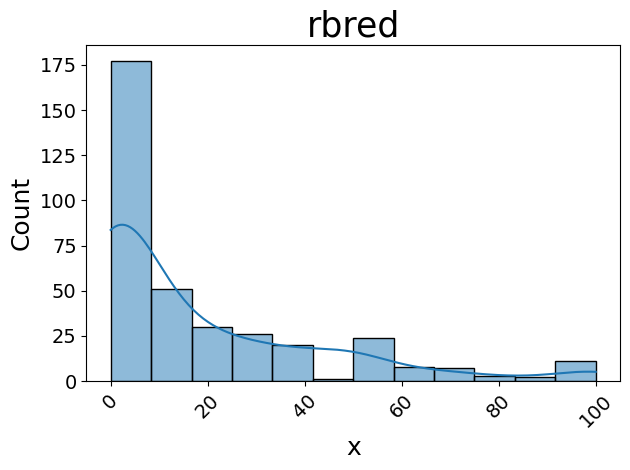

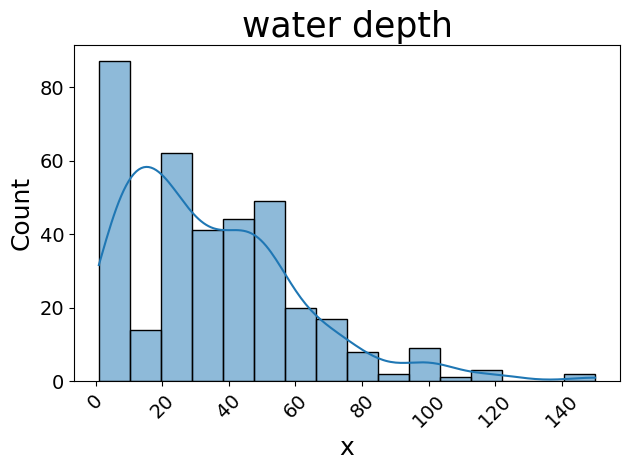

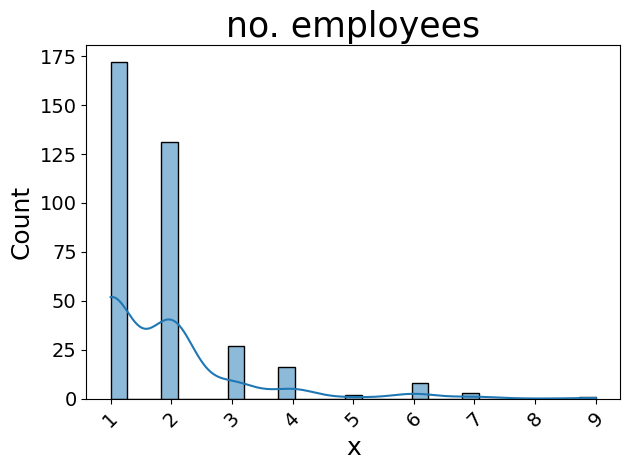

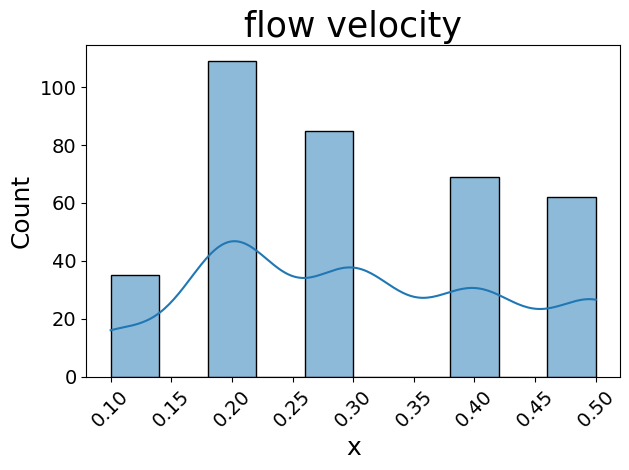

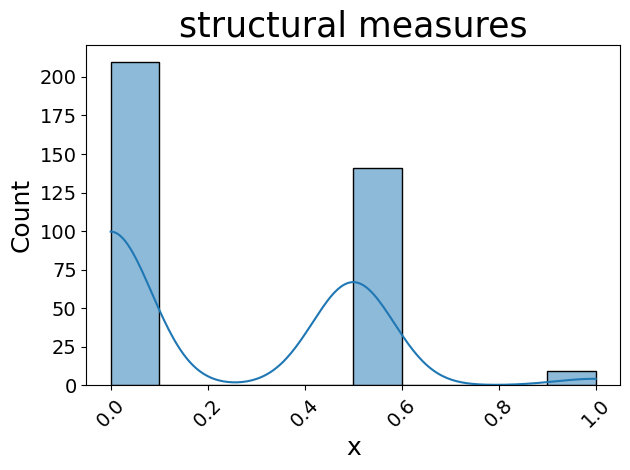

'BN plot saved in : c:\\Users\\Anna\\Documents\\UNI\\MA_topic\\master thesis\\flood-loss-models-4-HCMC-remote\\microbusiness-paper\\bayesian-network\\BN_visualize_bn_structure_rbred_margins.pdf'

In [13]:
# '# #-----------------------------------------------------------------------------
# Function 2 - bn_visualize - Plot of the Bayesian Network
#-----------------------------------------------------------------------------

##  BN structure with graph + rank correlations on all b.reduction samples

## TODO change pybanhsee package for figure: make outpath adding possible (maybe rm prefix "BN_visualize_")
fig_name =  f"bn_structure_{target}"

df_hcmc_bn_plot = df_hcmc_bn # .rename(

bn_visualize(parent_cell,           # structure of the BN
             R,                     # the rank correlation matrix (function 1)
             df_hcmc_bn_plot.columns,          # names of variables
             fig_name = fig_name)   # figure name
# The plot presents the BN with x nodes and x arcs, with the (conditional)
# rank correlations indicated on the arcs.

bn_visualize(parent_cell,                       # structure of the BN
             R,                                 # the rank correlation matrix 
             df_hcmc_bn_plot.columns,                      # names of variables
             data = df_hcmc_bn_plot,                       # DataFrame with data
             fig_name = fig_name + '_margins')  # figure name




## Copula test

<Figure size 2000x1500 with 0 Axes>

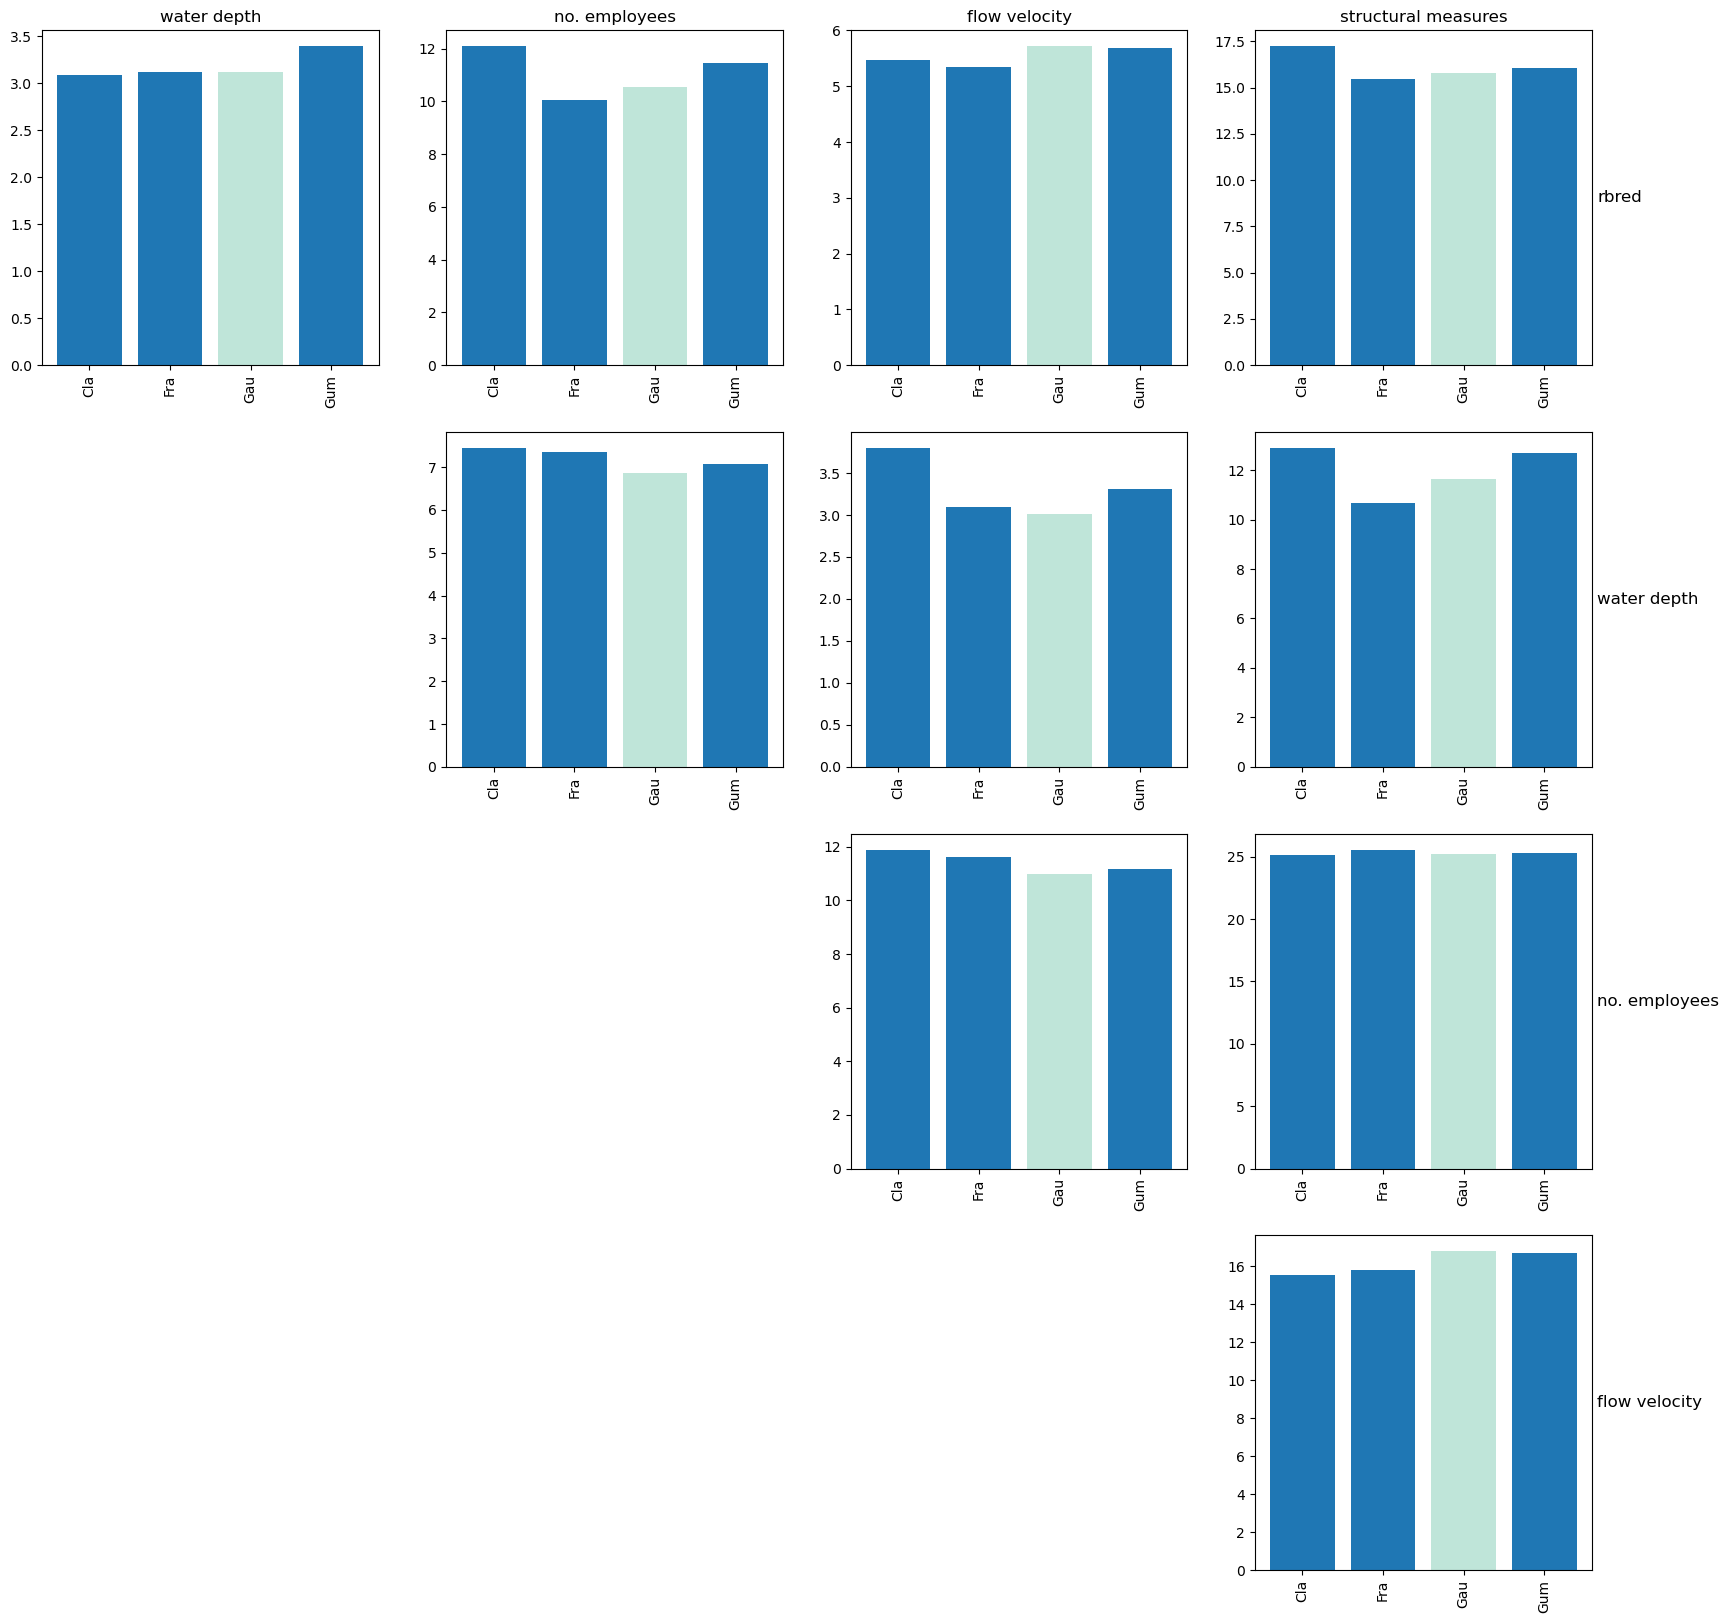

In [14]:
#-----------------------------------------------------------------------------
# Function 3 - cvm_statistics - test goodness-of-fit of the Gaussian copula 
#-----------------------------------------------------------------------------

plt.figure(figsize=(20,15))
M = cvm_statistic(df_hcmc_bn,                   # df_predictorsFrame with df_hcmc
                  names = df_hcmc_bn.columns,   # names of variables
                  plot = True,               # create a plot (0=don"t create plot)
                  fig_name = "empricial_corpula_all vars_rbred")    # figure name
                  
# The results of the goodness-of-fit test in terms of Cramer-von Mises
# statistic highlight that the Gaussian copula is in majority of cases the 
# most suitable for representing the dependency between variables, 
# especially for the variable of interest (safety). This is important as
# the method utilizes the Gaussian copula for dependence modelling.



##### d-calibration score

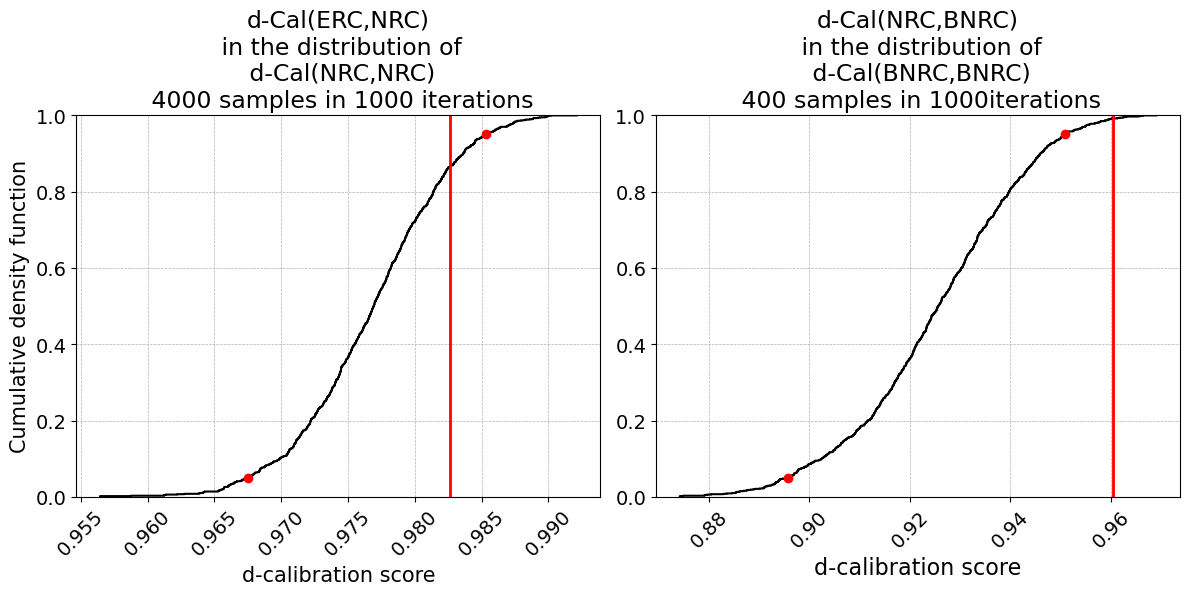

SUCCESS: The d-Cal of the empirical rank correlation matrix (ERC) fall between the confidence intervals of the d-Cal of the normal rank correlation matrix (NRC)

FAILURE: The d-Cal of the normal rank correlation matrix (NRC) is out of the confidence intervals of the d-Cal of the BN rank correlation matrix (BNRC)



In [15]:
# -----------------------------------------------------------------------------
# Function 4 - gaussian_distance - measuring d-calibration score
# -----------------------------------------------------------------------------


# gaussian_distance : validation: 
D_ERC,B_ERC,D_BNRC,B_BNRC = gaussian_distance(
                            R,        # the rank correlation matrix 
                            df_hcmc_bn,     # df_predictorsFrame with df_hcmc
                            4000,     # number of samples drawn d-Cal(ERC,NRC)
                            400,      # number of samples drawn d-Cal(NRC,BNRC)
                            1000,     # number of iterations to compute CI
                            Plot=True,          # create a plot (0=don"t create plot)
                            Type="H",           # take Hellinger distance (default)
                            fig_name=fig_name)  # figure name

                        
# draw 4000 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (ERC,NRC)
# draw 400 samples of the normal distribution and perform 1000 iterations to
# obtain the distribution of the d-cal score (NRC,BNRC)


# The d-calibration score of the BN"s rank correlation matrix is well within  
# the 90# confidence interval of the determinant of the random normal distribution 
# sampled for the same correlation matrix. This supports the assumptions of
# a joint normal copula used in the BN model. It should be noted that the 
# test is sensitive to the number of samples drawn as well as the number of 
# iterations and is rather severe for large df_predictor sets.


## Evaluation: HCMC


In [16]:
## add binary dummy var for plotting zero-damage vs damage cases
residuals_hcmc["binary_true_dummy"] = 0
idx_damage = np.where(residuals_hcmc["y_true"] >= 1)[0]
residuals_hcmc["binary_true_dummy"].iloc[idx_damage] = 1


## add residuals
residuals_hcmc["residual"] = residuals_hcmc["y_pred"] - residuals_hcmc["y_true"]

### plot obs ~ pred

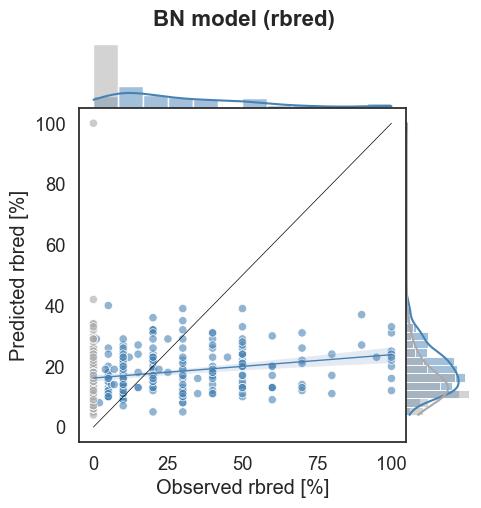

In [17]:
f.plot_observed_predicted(
    residuals_hcmc["y_true"], residuals_hcmc["y_pred"],  
    hue=residuals_hcmc["binary_true_dummy"], 
    hue_colors=("darkgrey","steelblue"), # if differentiation: set both time the same color
    xlabel=f"Observed {target_plot} [%]", ylabel=f"Predicted {target_plot} [%]",
    legend=False,
    figure_title="BN model (rbred)",
    outfile= f"{OUTPATH_BN}/scatter_obs_pred_{target_plot}_hcmc.png"
)   

### Main validation results

In [18]:
## get ratio of damage cases vs total reported bred

c = "y_pred"
print(len(np.where(residuals_hcmc[c] > 0.0)[0])) 
print(len(np.where(residuals_hcmc[c] > 0.0)[0]) / len(residuals_hcmc[c]) * 100, "%")
np.mean(residuals_hcmc[c])


360
100.0 %


17.53611111111111

#### Plot residuals

**test residuals grouped by sales / sector**

In [19]:
df_hcmc.describe()


,rbred,emergency measures,building age,water depth,no. employees,flow velocity,flood experience,resilience,inundation duration,structural measures,mthly. sales,non-structural measures,building area,mthly. income,contaminations
count,360.000000,360.000000,337.000000,359.000000,360.000000,360.000000,360.000000,360.000000,353.000000,360.000000,360.000000,360.000000,358.000000,342.000000,360.000000
mean,18.238889,0.411574,19.821958,34.674095,1.852778,0.303889,81.780556,2.586111,11.333428,0.220833,365.456389,0.359028,86.250000,428.020468,0.991667
std,24.892608,0.262665,14.219508,26.330456,1.209523,0.125502,53.570500,1.051204,29.173299,0.272683,438.764636,0.296958,86.668041,365.265865,0.391323
min,0.000000,0.000000,0.000000,1.000000,1.000000,0.100000,3.000000,0.000000,0.200000,0.000000,92.100000,0.000000,12.000000,18.400000,0.000000
25%,0.000000,0.166667,11.000000,15.000000,1.000000,0.200000,36.000000,1.750000,2.000000,0.000000,92.100000,0.187500,42.000000,294.600000,1.000000
50%,10.000000,0.500000,18.000000,30.000000,2.000000,0.300000,76.000000,2.500000,3.000000,0.000000,276.200000,0.250000,75.000000,294.600000,1.000000
75%,30.000000,0.666667,24.000000,50.000000,2.000000,0.400000,151.000000,3.500000,6.000000,0.500000,276.200000,0.500000,100.000000,552.400000,1.000000
max,100.000000,1.000000,100.000000,150.000000,9.000000,0.500000,151.000000,5.000000,240.000000,1.000000,2761.900000,1.000000,850.000000,3314.300000,2.000000


(360, 4)


(163, 4)


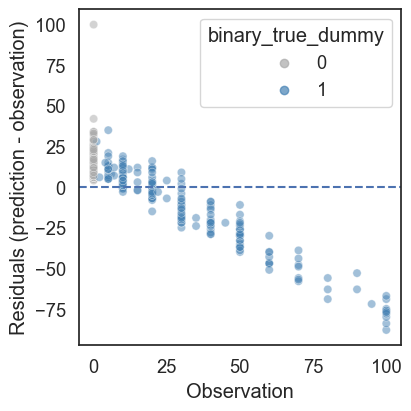

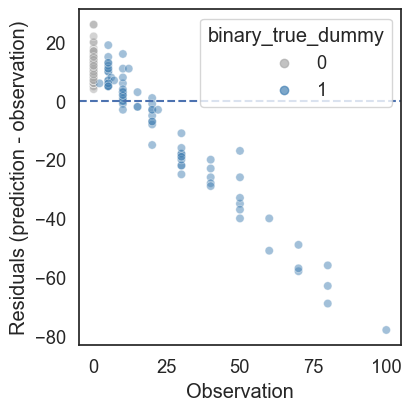

In [20]:
print(residuals_hcmc.shape)
f.plot_residuals_single(residuals_hcmc["y_true"], residuals_hcmc["residual"], residuals_hcmc["binary_true_dummy"],)

# idx = df_hcmc.loc[df_hcmc["mthly. sales"]>300, :].index
# idx = df_hcmc.loc[df_hcmc["water depth"] < 30, :].index
idx = df_hcmc.loc[df_hcmc["water depth"] < 30, :].index

residuals_hcmc_subset = residuals_hcmc.iloc[idx, :]

print(residuals_hcmc_subset.shape)
f.plot_residuals_single(residuals_hcmc_subset["y_true"], residuals_hcmc_subset["residual"], residuals_hcmc_subset["binary_true_dummy"],)

## tested groups
## --> sales: no pattern of over/underestimation tendency visual visible for sale groups
## --> wd: when wd > 30m and sm losses occured than they are rather predictedoverestiated by the model (compared to residuals based on all samples)
##      wd < 30 and small losses are predicted with smaller overestimation bias

## Model transferability
Test trained NPBN for CanTHo DS

In [21]:
infile_name = "input_data_businessreduction_cantho"
df_cantho = pd.read_excel(f"{INPATH_DATA}/{infile_name}.xlsx")

##  use nice feature names
df_cantho.rename(columns=s.feature_names_plot, inplace=True) 

## prepare CanTHo for BN - adpat with same column structure as training dataset
df_cantho_bn = df_cantho[df_hcmc_bn.columns]
 
print(df_cantho_bn.shape)
df_cantho_bn.tail(2)

(313, 5)


,rbred,water depth,no. employees,flow velocity,structural measures
311,50,20,4,0.3,0.666667
312,50,50,1,0.2,0.333333


### Prediction and Evaluation on CanTho Bred

#### Conditionalize with all parent nodes

In [22]:
condition

[1, 2, 3, 4]

In [23]:
condition = [1, 2, 3, 4]
values = df_cantho_bn.iloc[:,condition].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_bn,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_bn,        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="mean")    # type of output data

print("Inference - Uncertainty distribution: ", pd.Series(F.squeeze()).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F.squeeze()
y_true = df_cantho_bn.iloc[:,0].to_numpy()


# evaluation metrics
MAE = eu.mean_absolute_error(y_true, y_pred)
MBE = eu.mean_bias_error(y_true, y_pred)
RMSE = eu.root_mean_squared_error(y_true, y_pred) # (np.mean((y_pred - y_true)**2))**(1/2)
SMAPE = eu.symmetric_mean_absolute_percentage_error(y_true, y_pred)

print("MAE,:", MAE)  
print("MAE, MBE, RMSE, SMAPE:", MAE, MBE, RMSE, SMAPE)  

print(f"\nObserved and predicted target distribution for CanTho:")
eu.empirical_vs_predicted(y_true, y_pred)

Inference - Uncertainty distribution:  count    313.000000
mean      40.733741
std        8.552899
min       25.372400
25%       36.074800
50%       39.855000
75%       44.210100
max      100.100000
dtype: float64
MAE,: 17.815780191693293
MAE, MBE, RMSE, SMAPE: 17.815780191693293 -0.1288785942492011 23.49978653239461 23.175766846771083

Observed and predicted target distribution for CanTho:


,nobs,median,mean,min max,variance,standard deviation,coef. of variation
empirical,313,40.0,40.862620,"[0, 100]",477.46,21.82,53.473876
predicted,313,39.0,40.242812,"[25, 100]",73.57,8.56,21.313721


In [24]:
## BN predict on Can Tho 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_bn,        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="mean")    # type of output data
              #Output="median")    # type of output data


In [25]:
residuals_cantho = pd.DataFrame(
            {
                "y_true": pd.Series(y_true),
                "y_pred": pd.Series(y_pred),
                "residual": pd.Series(y_pred) - pd.Series(y_true),  # + residual=overestim, -residual=underestimation of model
            },
            index=pd.Series(y_true).index)

## add binary dummy var for plotting zero-damage vs damage cases
residuals_cantho.reset_index(drop=True, inplace=True)
residuals_cantho["binary_true_dummy"] = 0
idx_damage = np.where(residuals_cantho["y_true"] >= 1)[0]
residuals_cantho.loc[idx_damage, "binary_true_dummy"] = 1
residuals_cantho.describe()


print("Bred, cantho")
print(residuals_cantho.describe())


Bred, cantho
           y_true      y_pred    residual  binary_true_dummy
count  313.000000  313.000000  313.000000         313.000000
mean    40.862620   40.733741   -0.128879           0.977636
std     21.850827    8.552899   23.537062           0.148102
min      0.000000   25.372400  -65.280600           0.000000
25%     25.000000   36.074800  -12.305100           1.000000
50%     40.000000   39.855000    1.540100           1.000000
75%     50.000000   44.210100   14.564300           1.000000
max    100.000000  100.100000  100.100000           1.000000


Plot obs ~ pred

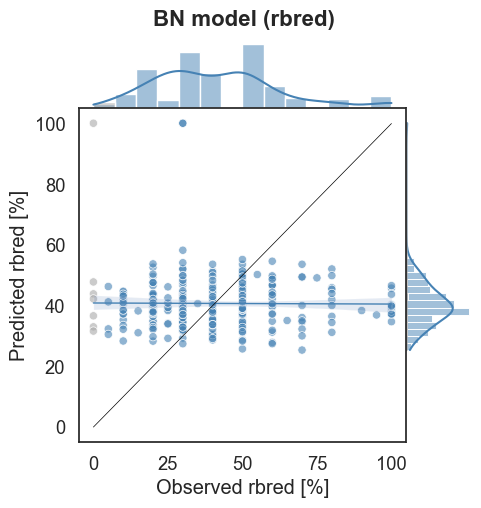

In [26]:
f.plot_observed_predicted(
    residuals_cantho["y_true"], residuals_cantho["y_pred"],  
    hue=residuals_cantho["binary_true_dummy"],
    xlabel=f"Observed {target_plot} [%]", ylabel=f"Predicted {target_plot} [%]",
    legend=False,
    figure_title="BN model (rbred)",
    outfile= OUTPATH_BN + f"scatter_obs_pred_{target_plot}_cantho.png"
)       

# plt.xlabel("Model transferability, tested on Can Tho dataset")
# plt.show()

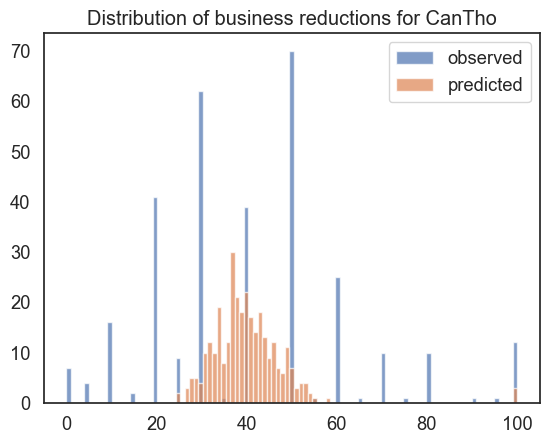

In [27]:
bins = np.linspace(0, 100, 100)

plt.hist((pd.Series(y_true.astype(int))), bins, alpha=0.7, label="observed")
plt.hist((pd.Series(y_pred.astype(int))), bins, alpha=0.7, label="predicted")
plt.legend(loc="upper right")
plt.title("Distribution of business reductions for CanTho")
plt.show()


### Main validation results


In [28]:
## get daamge / total
len(np.where(y_pred>0)[0])
np.mean(y_pred)

40.73374121405751

#### Plot residuals

Text(0, 0.5, 'residuals (prediction - observation)')

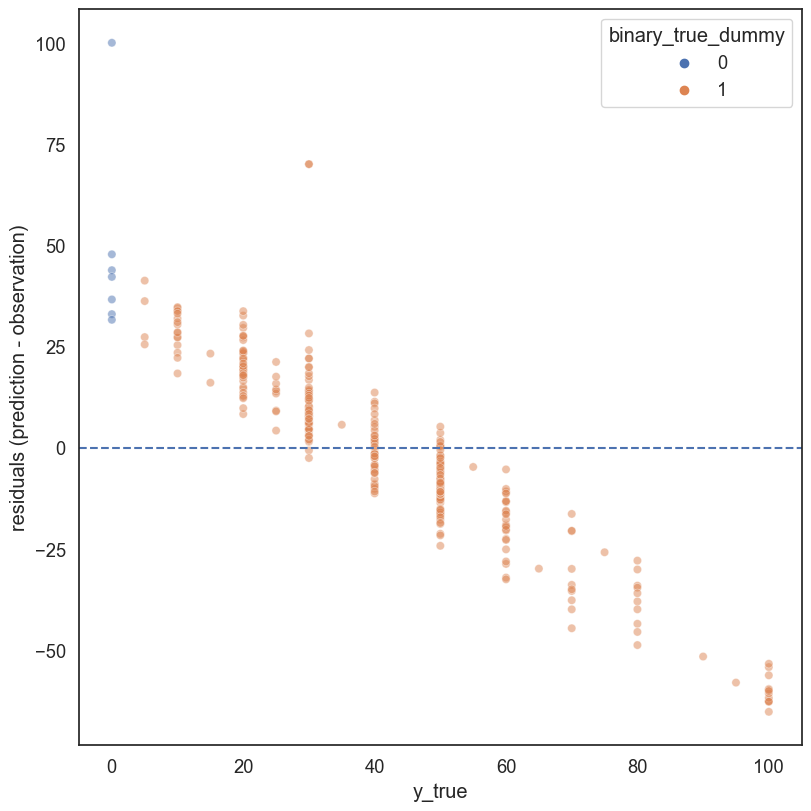

In [29]:
from matplotlib.colors import to_rgba

fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)

hue_colors=("darkgrey","steelblue")
alpha=0.7

color_dict = {
    0: to_rgba(hue_colors[0], alpha), # set transparency for each class independently
    1: to_rgba(hue_colors[1], alpha)
}
ax.axhline(0, ls='--')
sns.scatterplot(
    x = residuals_cantho["y_true"], 
    y = residuals_cantho["residual"], # pred - obs 
    hue = residuals_cantho["binary_true_dummy"],
    alpha = 0.5,

)
plt.ylabel("residuals (prediction - observation)")





### CDFs: Plot prediction bias between HCMC and Can Tho
Cumulative error of predictions for HCMC and Can THo

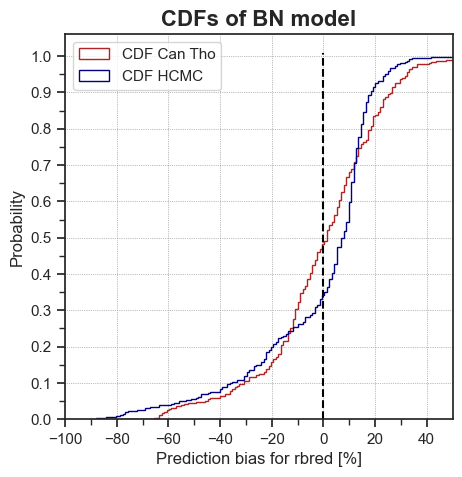

In [ ]:

sns.set(rc={"xtick.bottom" : True, "ytick.left" : True})
sns.set_style(
    style="ticks",
     rc={"axes.grid" : False, "grid.linestyle": ":"}
     )

fig, ax = plt.subplots(1, 1, figsize=(5,5))

p, bins, patches  = ax.hist(
    [residuals_hcmc["residual"], residuals_cantho["residual"]],  # pred HCMC+CanTHo rbred
    bins=200,
    density=True, # alias for normalize, last bins equals 1
    cumulative=True,  
    histtype='step', 
    alpha=1.,
    color=("navy","firebrick"), 
    label=( "CDF HCMC", "CDF Can Tho"),
)

ax.grid( which='major', color='grey', linewidth=0.5)

## entire CDF
plt.xlim(-100, 50)
plt.xticks(np.arange(-100, 50, 20), minor=False)
plt.xticks(np.arange(-100, 50, 10), minor=True)
plt.yticks(np.arange(0, 1.01, 0.1))
plt.yticks(np.arange(0.0, 1.0, 0.05), minor=True)


plt.xlabel("Prediction bias for rbred [%]")
plt.ylabel("Probability")
plt.legend(loc='best')

plt.vlines(x=0, ymin=0, ymax=1.01, colors="black", linestyles="--")

plt.title("CDFs of BN model", fontweight="bold", fontsize=16)
plt.savefig(OUTPATH_BN + "./cdf_bn_rbred.png", dpi=300, bbox_inches="tight")





In [59]:
eu.symmetric_mean_absolute_percentage_error(pd.Series(50), pd.Series(20))

42.857142857142854

<function silent_list.count(value, /)>

In [35]:
residuals_cantho[(residuals_cantho["residual"] >=-10) & (residuals_cantho["residual"] <=10)]

# % of sampels preidcted with less than +-10% preidction bias
# BN : hcmc 123/ 360   = 34 # cantho 114 / 313  # 36

,y_true,y_pred,residual,binary_true_dummy
0,40,47.2057,7.2057,1
1,50,43.7352,-6.2648,1
3,50,40.2853,-9.7147,1
5,40,39.8599,-0.1401,1
7,40,41.3598,1.3598,1
...,...,...,...,...
302,40,39.3147,-0.6853,1
303,40,39.7148,-0.2852,1
304,40,33.4595,-6.5405,1
309,30,37.1849,7.1849,1


0.36421725239616615

## Uncertainties in rbred predictions

In [ ]:
condition = condition
print("condition: ", condition)
values = df_cantho_bn.iloc[:,condition].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_bn,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference(condition,        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_bn,        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="full")    # type of output data

# print("Inference - Uncertainty distribution: ", pd.Series(F()).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F.squeeze()
y_true = df_cantho_bn.iloc[:,0].to_numpy()


### avg. uncertainties
dict = {}

for i in range(0,1000):
    nth_sample  = [ e[i] for e in y_pred ]
    dict[i] = nth_sample

df_uncertainties = pd.DataFrame.from_dict(dict).T  # cols: flood cases, rows: sample number 
df_uncertainties.tail(10)


# df_uncertainties_avg = df_uncertainties

df_uncertainties_c_p = pd.DataFrame()
df_uncertainties_c_p["avg_modelled"] = df_uncertainties.mean(axis=0)
df_uncertainties_c_p["observed"] = df_cantho_bn["rbred"]
df_uncertainties_c_p["city"] = "Can Tho"


condition:  [1, 2, 3, 4]


In [ ]:
## uncertainties for sparse BN

values = df_cantho_bn.iloc[:,[2, 3, 4]].to_numpy() # data for conditionalization

# BN define rank corr coefs on HCMC
R = bn_rankcorr(parent_cell,        # structure of the BN
            df_hcmc_bn,  
            var_names = names,  # names of variables
            is_data = True,        # matrix data contains actual data
            plot = False)  

## BN predict on Can Tho 
F = inference([2, 3, 4],        # nodes that will be conditionalized
              values,           # information used to conditionalize the nodes of the NPBN
              R,                # the rank correlation matrix from HCMC ds
              df_cantho_bn,        # DataFrame for cantho
              SampleSize=1000, Interp='next',
              Output="full")    # type of output data
              #Output="median")    # type of output data


## inference of node for water depth and node for target
F_water = [row[0] for row in F]
F_target = [row[1] for row in F]
print("Inference - Uncertainty distribution: ", pd.Series(F_target).describe())  #y_pred freq

## predict target and observed tagret
y_pred = F_target
y_true = df_cantho_bn.iloc[:,0].to_numpy()


dict = {}
for i in range(0,1000):
    nth_sample  = [ e[i] for e in y_pred ]
    dict[i] = nth_sample

df_uncertainties = pd.DataFrame.from_dict(dict).T  # cols: flood cases, rows: sample number 
df_uncertainties.tail(10)

# df_uncertainties_avg = df_uncertainties

df_uncertainties_c_sparse_p = pd.DataFrame()
df_uncertainties_c_sparse_p["avg_modelled"] = df_uncertainties.mean(axis=0)
df_uncertainties_c_sparse_p["observed"] = df_cantho_bn["rbred"]
df_uncertainties_c_sparse_p["city"] = "Can Tho - sparse"


Inference - Uncertainty distribution:  count                                                   313
unique                                                  313
top       [50.0, 20.0, 30.0, 40.0, 50.0, 40.0, 20.0, 40....
freq                                                      1
dtype: object


In [ ]:
## join uncertainites from BNs for hcmc, cantho, and cantho-sparse 

df_uncertainties_hc_sparse_p = pd.concat([df_uncertainties_p, df_uncertainties_c_p, df_uncertainties_c_sparse_p], axis=0)
df_uncertainties_hc_sparse_p
# df_uncertainties_hc_p = pd.melt(df_uncertainties_hc_p, id_vars=['city'], var_name=['city'])
print(df_uncertainties_hc_sparse_p)


     avg_modelled  observed              city
0         14.2137         0              HCMC
1         14.0954         0              HCMC
2          9.2884         0              HCMC
3         12.8237         0              HCMC
4          9.8508         0              HCMC
..            ...       ...               ...
308       12.8338       100  Can Tho - sparse
309       20.6899        30  Can Tho - sparse
310       20.5528       100  Can Tho - sparse
311       16.6843        50  Can Tho - sparse
312       17.0942        50  Can Tho - sparse

[986 rows x 3 columns]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


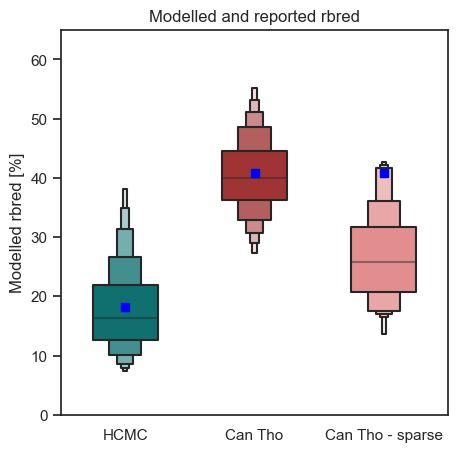

In [ ]:
group = "city"
column = "avg_modelled"
scatterpoints="observed"


grouped = df_uncertainties_hc_sparse_p.groupby(group)
categories = np.unique(df_uncertainties_hc_sparse_p[scatterpoints])
colors = np.linspace(0, 1, len(categories))


names, vals, xs, colrs = [], [] ,[], []

for i, (name, subdf) in enumerate(grouped):
    names.append(name)
    vals.append(subdf[column].tolist())
    xs.append(np.random.normal(i+1, 0.04, subdf.shape[0]))
    colrs.append(subdf[scatterpoints].tolist())

# fig = plt.figure()
# ax = fig.add_subplot(111)
fig, ax = plt.subplots(figsize=(5, 5))
fig.canvas.draw()


## average predicted means
p = sns.boxenplot(
    x = df_uncertainties_hc_sparse_p["city"],
    y = df_uncertainties_hc_sparse_p["avg_modelled"],
    width=.5,
    showfliers=False,
    # showmeans=True,
    palette=["teal", "firebrick", "lightcoral"],
    line_kws={"linewidth":1.5},# color":"cde"
    flier_kws={"facecolor":.7, "linewidth":.5},
)

# observed mean
sns.boxplot(
    x = df_uncertainties_hc_sparse_p["city"],
    y = df_uncertainties_hc_sparse_p["observed"],
    # labels="HCMC",
    showfliers=False,
    showmeans=True,
    medianprops={"color": "r", "linewidth": 0, "alpha":0.0},
    boxprops={"facecolor":"steelblue", "alpha":0.0},
    whiskerprops={"color":"k", "alpha":0.},
    capprops={"color":"k", "alpha":0},
    meanprops={"marker":"s", "markerfacecolor":"blue", "markeredgecolor":"blue"}
)

p.tick_params(bottom=False)  # remove x ticks
plt.legend().set_visible(False)  # surpress legend

plt.ylim(0, 65)
plt.ylabel(f"Modelled {target} [%]")
plt.xlabel(f"")
plt.title("Modelled and reported rbred")
plt.savefig(OUTPATH_BN + f"uncertainties_{target}.png", dpi=300, bbox_inches="tight")
